## Build Current Model
---


In [1]:
try:
    import autogluon
except:
    !python3 -m pip install --upgrade pip
    !python3 -m pip install --upgrade "mxnet<2.0.0"
    !python3 -m pip install autogluon
    !pip install bokeh==2.0.1

In [2]:
import os, sys
import json
import pickle as pkl
import pandas as pd
import autogluon as ag
from autogluon import TabularPrediction as task

from rdsutils import datagen
from rdsutils import plot
from utils import preprocess

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
modeling_df = pd.read_parquet('../../artifacts/final/modeling_df_w_baselines.parquet')

In [4]:
seed = 12345
target_col = 'ach_target'
id_col = 'business_account_number'
features = pkl.load(open('../../artifacts/final/features_corr_removed.pkl', 'rb'))

In [5]:
modeling_df.head()

,user_id,business_account_number,transaction_datetime,transaction_code,is_return,transaction_amount,endbal,external_account_number,real_ending_balance,external_institution_id,...,return_dollar_amount,dollar_val_returns,dollar_val_returns_3d,transaction_date,account_ending_balance,days_since_first_transaction,ach_target,fico_pred,deposit_v1_pred,customer_pred
10224161,2739821,410000070632,2020-05-19 18:01:26,ACHDD,False,88.0,610.73,101434249,35259.43,031176110,...,-0.0,0.0,4.440892e-16,2020-05-19,35259.43,847.0,False,NaN,0.004101,0.000916
9871303,3599351,410000070641,2020-05-08 18:01:05,ACHDD,False,120.0,620.09,3533131722724,6439.15,124085244,...,-0.0,120.0,0.000000e+00,2020-05-08,6439.15,785.0,False,NaN,0.094721,0.004485
10332885,3599351,410000070641,2020-05-22 18:01:05,ACHDD,False,120.0,386.81,3533131722724,6472.36,124085244,...,-0.0,120.0,0.000000e+00,2020-05-22,6472.36,799.0,False,NaN,0.087164,0.006790
10818509,3599351,410000070641,2020-06-04 18:01:06,ACHDD,False,120.0,506.89,3533131722724,6592.44,124085244,...,-0.0,120.0,0.000000e+00,2020-06-04,6592.44,812.0,False,NaN,0.087164,0.005704
11383098,3599351,410000070641,2020-06-19 18:01:26,ACHDD,False,120.0,620.00,3533131722724,6712.44,124085244,...,-0.0,120.0,0.000000e+00,2020-06-19,6712.44,827.0,False,NaN,0.087164,0.005113


In [6]:
modeling_df = modeling_df[features+[target_col, id_col]]
modeling_df = preprocess(modeling_df)

### Train-test-split
---

In [7]:
modeling_dfs = datagen.GroupKFoldGenerator(modeling_df, 5, seed=seed,
                              strategize_by='ach_target', 
                              groupby='business_account_number')
train, test = next(modeling_dfs)

In [8]:
modeling_dfs_ = datagen.GroupKFoldGenerator(train, 4, seed=seed,
                              strategize_by='ach_target', 
                              groupby='business_account_number')
train, valid = next(modeling_dfs_)

In [9]:
train.shape, valid.shape, test.shape, modeling_df.shape

((67559, 30), (22520, 30), (22520, 30), (112599, 30))

### AutoGluon Data
---

In [10]:
pos_wgt_scaling_factor = datagen.get_positive_label_weight(modeling_df[target_col])

train_data = task.Dataset(df=train[features+[target_col]+[id_col]])
valid_data = task.Dataset(df=valid[features+[target_col]+[id_col]])
test_data = task.Dataset(df=test[features+[target_col]+[id_col]])

In [11]:
train_data.head()

,vantage_score,first_deposit_amount,bcc7120,credit_card_loan_amount,plaid_max_avail_bal,total_tradelines_open,plaid_days_since_first_link,nr_transactions_30d_div_nr_past_transactions,plaid_min_avail_bal,nr_transactions_per_day,...,email_risk_score,deposits_ratio,fraud_score_1,mean_deposits_10d_div_mean_deposits,fraud_score_2,nr_past_deposits,quovo_min_avail_bal,address_risk_score,ach_target,business_account_number
10224161,NaN,100.0,-1.0,-1.0,NaN,-1.0,-1.0,0.061069,NaN,0.773318,...,0.197,0.012390,0.0163,0.175484,0.428,189,NaN,0.137,False,410000070632
9871304,NaN,10.0,-1.0,-1.0,NaN,-1.0,-1.0,0.027894,NaN,1.713262,...,0.041,0.250591,0.0130,1.397557,0.266,200,NaN,0.171,False,410000070650
10332889,NaN,10.0,-1.0,-1.0,NaN,-1.0,-1.0,0.028826,NaN,1.712103,...,0.041,0.174317,0.0130,2.560334,0.266,200,NaN,0.171,False,410000070650
10441955,NaN,10.0,-1.0,-1.0,NaN,-1.0,-1.0,0.025992,NaN,1.709942,...,0.041,0.055018,0.0130,1.792651,0.266,200,NaN,0.171,False,410000070650
10818513,NaN,10.0,-1.0,-1.0,NaN,-1.0,-1.0,0.025187,NaN,1.700231,...,0.041,0.015171,0.0130,0.451187,0.266,200,NaN,0.171,False,410000070650


### Train Models
---

In [13]:
metric = 'f1'   # 'roc_auc', 'f1', 'average_precision'
path = '../../artifacts/autogluon-ach'
os.makedirs(path, exist_ok=True)
hp_tune = True
time_limits = 10*60  # 2mins

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'objective' : 'binary',
    'metric' : 'auc',
    'boosting': 'gbdt',
    'tree_learner': 'serial',
    'boost_from_average': 'false',
    'tree_learner': 'feature',
    'num_leaves' : ag.space.Int(lower=5, upper=20, default=10),
    'lambda_l1': ag.space.Real(lower=0, upper=30, default=10),
    'lambda_l2': ag.space.Real(lower=0, upper=30, default=10),
    'min_data_in_leaf': ag.space.Int(lower=10, upper=50, default=30),
    'max_depth' : ag.space.Int(lower=2, upper=5, default=3),
    'num_boost_round': ag.space.Int(lower=100, upper=2000, default=500),
    'learning_rate': ag.space.Real(1e-3, 1e-1, default=1e-2),
    'feature_fraction' : ag.space.Real(0.1, 0.8, default=0.5),
    'scale_pos_weight': pos_wgt_scaling_factor,
    'early_stopping_round': 300,
    'seed': 12345,
    'seed_value': 12345
}

  
predictor = task.fit(train_data=train_data, 
                     tuning_data=valid_data,
                     label=target_col, 
                     output_directory=path, 
                     eval_metric=metric,
                     time_limits=time_limits,
                     hyperparameter_tune=hp_tune,
                     hyperparameters={'GBM':gbm_options},
                     search_strategy='skopt',
                     random_seed=seed) 

Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to ../../artifacts/autogluon-ach/
AutoGluon Version:  0.0.14
Train Data Rows:    67559
Train Data Columns: 27
Tuning Data Rows:    22520
Tuning Data Columns: 27
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [False, True]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = True, class 0 = False
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    62567.76 MB
	Train Data (Original)  Memory Usage: 19.46 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of t

Time out (secs) is 540.0
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[114]	train_set's auc: 0.964652	train_set's binary_logloss: 0.248181	train_set's f1: 0.410763	valid_set's auc: 0.930713	valid_set's binary_logloss: 0.250407	valid_set's f1: 0.393162


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[440]	train_set's auc: 0.955891	train_set's binary_logloss: 0.267125	train_set's f1: 0.392173	valid_set's auc: 0.931804	valid_set's binary_logloss: 0.265741	valid_set's f1: 0.387013


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[190]	train_set's auc: 0.944212	train_set's binary_logloss: 0.287087	train_set's f1: 0.361405	valid_set's auc: 0.931231	valid_set's binary_logloss: 0.284682	valid_set's f1: 0.361525


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds
[1000]	train_set's auc: 0.948218	train_set's binary_logloss: 0.279513	train_set's f1: 0.35982	valid_set's auc: 0.930646	valid_set's binary_logloss: 0.275821	valid_set's f1: 0.353878


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[445]	train_set's auc: 0.977713	train_set's binary_logloss: 0.215861	train_set's f1: 0.450435	valid_set's auc: 0.926582	valid_set's binary_logloss: 0.221788	valid_set's f1: 0.404878


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[116]	train_set's auc: 0.946208	train_set's binary_logloss: 0.286158	train_set's f1: 0.364569	valid_set's auc: 0.930945	valid_set's binary_logloss: 0.282657	valid_set's f1: 0.359652
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[180]	train_set's auc: 0.955816	train_set's binary_logloss: 0.274198	train_set's f1: 0.371144	valid_set's auc: 0.927718	valid_set's binary_logloss: 0.270199	valid_set's f1: 0.359503
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[184]	train_set's auc: 0.952499	train_set's binary_logloss: 0.271458	train_set's f1: 0.388285	valid_set's auc: 0.931001	valid_set's binary_logloss: 0.270585	valid_set's f1: 0.378413
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[60]	train_set's auc: 0.964888	train_set's binary_logloss: 0.24732

	Ran out of time, early stopping on iteration 168. Best iteration is:
	[166]	train_set's auc: 0.985789	train_set's binary_logloss: 0.18441	train_set's f1: 0.506594	valid_set's auc: 0.926144	valid_set's binary_logloss: 0.196065	valid_set's f1: 0.442654


	0.3816	 = Validation f1 score
	19.65s	 = Training runtime
	0.04s	 = Validation runtime
	0.3995	 = Validation f1 score
	10.23s	 = Training runtime
	0.03s	 = Validation runtime
	0.3054	 = Validation f1 score
	8.31s	 = Training runtime
	0.01s	 = Validation runtime
	0.4049	 = Validation f1 score
	23.64s	 = Training runtime
	0.05s	 = Validation runtime
	0.3597	 = Validation f1 score
	22.51s	 = Training runtime
	0.02s	 = Validation runtime
	0.3595	 = Validation f1 score
	25.24s	 = Training runtime
	0.03s	 = Validation runtime
	0.3784	 = Validation f1 score
	27.11s	 = Training runtime
	0.03s	 = Validation runtime
	0.3927	 = Validation f1 score
	20.79s	 = Training runtime
	0.02s	 = Validation runtime
	0.4016	 = Validation f1 score
	21.08s	 = Training runtime
	0.02s	 = Validation runtime
	0.3709	 = Validation f1 score
	19.18s	 = Training runtime
	0.01s	 = Validation runtime
	0.3587	 = Validation f1 score
	18.16s	 = Training runtime
	0.01s	 = Validation runtime
	0.3727	 = Validation f1 score
	2

In [14]:
try:
    y_true = test_data[target_col]
    test_data = test_data.drop(labels=[target_col], axis=1)
except:
    pass
test_data.head()

,vantage_score,first_deposit_amount,bcc7120,credit_card_loan_amount,plaid_max_avail_bal,total_tradelines_open,plaid_days_since_first_link,nr_transactions_30d_div_nr_past_transactions,plaid_min_avail_bal,nr_transactions_per_day,...,quovo_available_bal,email_risk_score,deposits_ratio,fraud_score_1,mean_deposits_10d_div_mean_deposits,fraud_score_2,nr_past_deposits,quovo_min_avail_bal,address_risk_score,business_account_number
10098926,NaN,5.00,-1.0,-1.0,NaN,-1.0,-1.0,0.020438,NaN,0.834348,...,0.0,0.150,0.863636,0.0312,8.061620,0.253,79,-773.96,0.057,410000070984
9944404,NaN,0.47,-1.0,-1.0,NaN,-1.0,-1.0,0.025496,NaN,0.435265,...,NaN,0.004,0.012772,0.0171,0.128112,0.109,91,NaN,0.155,410000071044
10572490,NaN,0.47,-1.0,-1.0,NaN,-1.0,-1.0,0.033241,NaN,0.435464,...,NaN,0.004,0.010098,0.0171,0.130139,0.109,94,NaN,0.155,410000071044
11464567,NaN,20.00,-1.0,-1.0,NaN,-1.0,-1.0,0.031339,NaN,0.409568,...,NaN,0.191,0.409836,0.0179,1.020947,0.137,98,NaN,0.333,410000071129
12642572,NaN,20.00,-1.0,-1.0,NaN,-1.0,-1.0,0.074074,NaN,0.426156,...,NaN,0.191,0.047733,0.0179,0.050202,0.137,101,NaN,0.333,410000071129


In [15]:
predictor = task.load(path)
y_pred = predictor.predict(test_data)
perf = predictor.evaluate_predictions(y_true=y_true, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: f1 on test data: 0.4318344039971449
Evaluations on test data:
{
    "f1": 0.4318344039971449,
    "accuracy_score": 0.9293072824156305,
    "balanced_accuracy_score": 0.8533381562046976,
    "matthews_corrcoef": 0.4535338249173475,
    "f1_score": 0.9293072824156305
}
Detailed (per-class) classification report:
{
    "False": {
        "precision": 0.9912691444737098,
        "recall": 0.9349926389400074,
        "f1-score": 0.9623088214404091,
        "support": 21736
    },
    "True": {
        "precision": 0.2998017839444995,
        "recall": 0.7716836734693877,
        "f1-score": 0.4318344039971449,
        "support": 784
    },
    "accuracy": 0.9293072824156305,
    "macro avg": {
        "precision": 0.6455354642091047,
        "recall": 0.8533381562046976,
        "f1-score": 0.697071612718777,
        "support": 22520
    },
    "weighted avg": {
        "precision": 0.967196746132018,
        "recall": 0.9293072824156305,
        "f1-score": 0.9438411507798621,

### Model Eval
---

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       weighted_ensemble_k0_l1   0.443681       0.180701  55.416832                0.038554           5.728819            1       True         23
1   LightGBMClassifier/trial_26   0.442654       0.030544   9.868069                0.030544           9.868069            0       True         17
2   LightGBMClassifier/trial_23   0.410021       0.025460   5.955391                0.025460           5.955391            0       True         14
3   LightGBMClassifier/trial_13   0.404878       0.052861  23.639524                0.052861          23.639524            0       True          4
4   LightGBMClassifier/trial_18   0.401620       0.018305  21.082163                0.018305          21.082163            0       True          9
5   LightGBMClassifier/trial_11   0.399462       0.03328

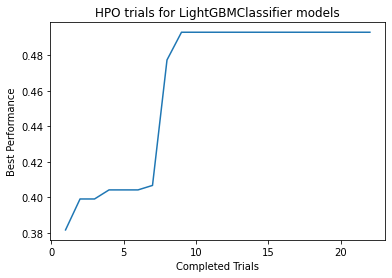

*** Details of Hyperparameter optimization ***
HPO for LightGBMClassifier model:  Num. configurations tried = 22, Time spent = 542.4201028347015s, Search strategy = skopt
Best hyperparameter-configuration (validation-performance: f1 = 0.4930399640772339):
{'feature_fraction': 0.743817471428067, 'lambda_l1': 30.0, 'lambda_l2': 1.0000671792272124, 'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 33, 'num_boost_round': 1904, 'num_leaves': 20}
*** End of fit() summary ***


In [16]:
predictor.fit_summary(3);

In [17]:
lb = predictor.leaderboard(test, silent=True, extra_info=True)
lb.head()

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,...,child_model_type,hyperparameters,hyperparameters_fit,AG_args_fit,features,child_hyperparameters,child_hyperparameters_fit,child_AG_args_fit,ancestors,descendants
0,LightGBMClassifier/trial_26,0.434845,0.442654,0.025709,0.030544,9.868069,0.025709,0.030544,9.868069,0,...,None,"{'num_boost_round': 2000, 'num_threads': 16, '...",{'num_boost_round': 166},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[vantage_score, first_deposit_amount, bcc7120,...",None,None,None,[],[weighted_ensemble_k0_l1]
1,weighted_ensemble_k0_l1,0.431834,0.443681,0.117521,0.180701,55.416832,0.004699,0.038554,5.728819,1,...,GreedyWeightedEnsembleModel,"{'max_models': 25, 'max_models_per_type': 5}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[LightGBMClassifier/trial_23, LightGBMClassifi...",{'ensemble_size': 100},{'ensemble_size': 54},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[LightGBMClassifier/trial_23, LightGBMClassifi...",[]
2,LightGBMClassifier/trial_23,0.400668,0.410021,0.018101,0.025460,5.955391,0.018101,0.025460,5.955391,0,...,None,"{'num_boost_round': 100, 'num_threads': 16, 'o...",{'num_boost_round': 100},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[vantage_score, first_deposit_amount, bcc7120,...",None,None,None,[],[weighted_ensemble_k0_l1]
3,LightGBMClassifier/trial_13,0.399344,0.404878,0.042872,0.052861,23.639524,0.042872,0.052861,23.639524,0,...,None,"{'num_boost_round': 445, 'num_threads': 16, 'o...",{'num_boost_round': 445},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[vantage_score, first_deposit_amount, bcc7120,...",None,None,None,[],[weighted_ensemble_k0_l1]
4,LightGBMClassifier/trial_11,0.390987,0.399462,0.026139,0.033282,10.225029,0.026139,0.033282,10.225029,0,...,None,"{'num_boost_round': 185, 'num_threads': 16, 'o...",{'num_boost_round': 183},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[vantage_score, first_deposit_amount, bcc7120,...",None,None,None,[],[weighted_ensemble_k0_l1]


In [18]:
def get_best_hyperparams(predictor, model_type, leader_board=None):
    """
    Get the hyperparams of the best model of <model_type> from AutoGluon predictor
    
    @returns model rank, model_params
    """
    import numpy as np
    
    if leader_board is None:
        leader_board = predictor.leaderboard(extra_info=True, silent=True)
    
    for rank, row in lb.iterrows():
        if model_type in row['model']:
            return (rank, row['model'], row['hyperparameters'])
    return (np.nan, "No such model found")

In [19]:
model_rank, model_name, lgbm_params = get_best_hyperparams(predictor, model_type='LightGBM', leader_board=lb)
display(model_name)
lgbm_params

'LightGBMClassifier/trial_26'

{'num_boost_round': 2000,
 'num_threads': 16,
 'objective': 'binary',
 'verbose': -1,
 'boosting_type': 'gbdt',
 'two_round': True,
 'metric': 'auc',
 'boosting': 'gbdt',
 'tree_learner': 'feature',
 'boost_from_average': 'false',
 'num_leaves': 20,
 'lambda_l1': 30.0,
 'lambda_l2': 1.6653345369377348e-15,
 'min_data_in_leaf': 50,
 'max_depth': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.8,
 'scale_pos_weight': 28.835453100158983,
 'early_stopping_round': 300,
 'seed': 12345,
 'seed_value': 12345}

In [20]:
model = model_name  # 'LightGBMClassifier', 'CatboostClassifier', 'weighted_ensemble_k0_l1'
predictor = task.load(path)
y_pred = predictor.predict_proba(test_data, model=model)
test['autogluon_final'] = y_pred

In [21]:
json.dump(lgbm_params, open('../../artifacts/final/final_params_cleaned.json', 'w'))